# Identifikace typu proměnných v přehlídce Northern Sky Variability Survey#
podle článku [Wozniak et.al](http://iopscience.iop.org/article/10.1086/425526/pdf)

In [16]:
%matplotlib inline
from __future__ import division

from astroquery.vizier import Vizier
import matplotlib.pylab as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
from astroML.datasets import fetch_sdss_sspp
from astroML.datasets import fetch_sdss_sspp
 
from astropy.table import Table,Column

Nejprve zjistíme, jaká data resp. jaké katalogy jsou dostupné s pomocí služby [Vizier](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/AJ/128/2965&-to=3) z výše zmíněného článku. Pro přístup k těmto službám použijeme metody z balíku [Astropy](http://www.astropy.org/)

In [17]:
catalog_list = Vizier.find_catalogs('J/AJ/128/2965/')

print catalog_list

{u'J/AJ/128/2965': <astropy.io.votable.tree.Resource object at 0x115ac1c50>}


Vidíme, že v datovém archívu je přístupný jeden katalog obsahující tabulku *table4*. S pomocí metody *get_catalogs* objektu *Vizier* tento katalog zpřístupníme. Výstupem je pak objekt [TableList](http://astroquery.readthedocs.org/en/latest/api/astroquery.utils.TableList.html#astroquery.utils.TableList). Obsah zvolené tabulku si pak jednoduše vypíšeme, abychom poznali její strukturu a názvy sloupců pomocí vnitřní metody *pprint*.

In [18]:
Vizier.ROW_LIMIT = -1
catalog = Vizier.get_catalogs('J/AJ/128/2965/table4')
catalog.ROW_LIMIT = -1

table = catalog['J/AJ/128/2965/table4']
table.pprint()


 _RAJ2000  _DEJ2000      NSVS       RAJ2000  ... Ksmag   J-H    H-Ks  Simbad
   deg       deg                      deg    ...  mag    mag    mag         
--------- --------- -------------- --------- ... ------ ------ ------ ------
  0.04172  74.13931 0000100+740822   0.04172 ...  5.204  1.067  0.350 Simbad
  0.07023  26.60787 0000169+263628   0.07023 ...  6.183  0.802  0.361 Simbad
  0.25647   6.45698 0001016+062725   0.25647 ...  6.484  0.707  0.578 Simbad
  0.28034  52.23316 0001073+521359   0.28034 ...  4.622  0.981  0.356 Simbad
  0.37078  31.79068 0001290+314726   0.37078 ...  4.486  0.923  0.310 Simbad
  0.41162  -3.75697 0001388-034525   0.41162 ...  7.030  0.864  0.362 Simbad
  0.50381  68.18202 0002009+681055   0.50381 ...  5.649  1.215  0.499 Simbad
  0.51437  53.98362 0002034+535901   0.51437 ...  4.831  1.001  0.386 Simbad
  0.58273  57.03661 0002199+570212   0.58273 ...  4.406  0.994  0.514 Simbad
  0.79019  44.15797 0003096+440929   0.79019 ...  5.488  0.883  0.368 Simbad

Připravíme si datový objekt, ve kterém každý řádek bude odpovídat jednomu prvku ze analýzované množiny a kadý sloupec bude odpovídat jednomu z popisných attributů. Tedy si připravíme matici o rozměru *n_samples x n_features*. V zvoleném článku autoři použili pět popisných parametrů - attributů *Perioda, Amplituda* a barvy *Rmag - Ksmag*, *J-H* a *H - Ks*. Atribut *Rmag* je [NSVS](http://skydot.lanl.gov/nsvs/nsvs.php) R-band magnituda, *Ksmag* je [2MASS](http://www.ipac.caltech.edu/2mass/) *Ks* band magnituda, dále *J-H* je [2MASS](http://www.ipac.caltech.edu/2mass/) (J-H) barva a podobně *H - Ks* je [2MASS](http://www.ipac.caltech.edu/2mass/) (H-Ks)

In [19]:
rmag_set = np.array(table['Rmag'])
Per_set = np.array(table['Per'])
Amp_set = np.array(table['Amp'])
ksmag_set = np.array(table['Ksmag'])
j_h_set = np.array(table['J-H'])
h_ks_set = np.array(table['H-Ks'])

rel_mag = rmag_set-h_ks_set

size = np.size(rmag_set)

#data = np.empty((size,3))
data = np.empty((size,5))

print 'Number of objects:',size

#data[:,0] = np.log10(rmag_set)
data[:,0] = np.log10(rel_mag)
data[:,1] = np.log10(Per_set)
data[:,2] = np.log10(Amp_set)

data[:,3] = np.log10(j_h_set)
data[:,4] = np.log10(h_ks_set)


Number of objects: 8678


### K-means clustering


Data máme již připraven pro aplikaci algoritmu *k-means clustering*. V našem případě budeme předpokládat existenci dvou skupin (clusterů) označených jako *M* a *SR-L*. Označení koresponduje s proměnnými hvězdami typu *Mira*  a dlouhoperiodickými proměnnými hvězdami. Nejprve inicializujeme náš statistický model - objekt *K-means*, na který pak aplikujeme na naše pozorovaná data s pomocí metody *fit*. 

In [20]:
number_of_cluster = 2

scaler = preprocessing.StandardScaler()

clf = KMeans(number_of_cluster,tol=1e-5)
clf.fit(data)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

In [21]:
label_class = table['_2Type']

class_type = preprocessing.LabelEncoder()
label_class_number = np.array(class_type.fit_transform(label_class))

print label_class_number

[1 1 0 ..., 1 0 1]


Vykreslíme se pozice hvězd v diagramu *log10(Per)* a *log10(Amp)* podle typu. K tomuto účelu si určíme souřadnice *x,y* pro oba typy a vykreslíme je do grafu včetně určených středů shluků

Výsledkem modelování je pozice středů jednotlivých shluků (clusterů). V našem případě jsou středy shluků vyznačeny červenou a zelenou barvou. Nyní porovnáme klasifikaci určenou pomocí naší metody *K-mean*, s výsledky klasifikace publikované v práci pro případ klasifikace na 2 typy. Nejprve si načteme si příslušný sloupec z tabulky (jméno sloupce *_2Type*). Sloupec obsahuje dva typy hvězd, typ *M* a typ *SR+L*. Se písmeným označením popisných parametrů (features) se pracuje velmi špatně, proto si je převedeme do číslené podoby. K tomu slouží metody z třídy [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) z balíku [sci-kit learn](http://scikit-learn.org/stable/), která převede znakovou klasifikaci *M*, *SR+L* na číselnou $0,1$

Number of M class: 2565
Number of SR-L class: 6113


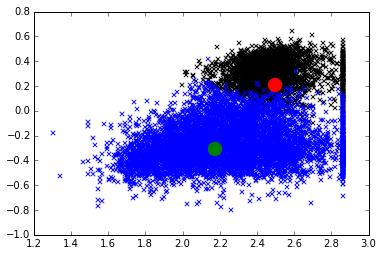

In [22]:
# Class M coordinates
indexes_M = np.where( label_class_number == 0)

x_M = data[indexes_M,1]
y_M = data[indexes_M,2]

number_of_class_M = np.size(x_M)
print 'Number of M class:',number_of_class_M

# Class SR+L coordinates
indexes_SR = np.where( label_class_number == 1)

x_SR = data[indexes_SR,1]
y_SR = data[indexes_SR,2]

number_of_class_SR = np.size(x_SR)
print 'Number of SR-L class:',number_of_class_SR

fig = plt.figure()
ax = plt.gca()

# Period vs. Amplitude
plt.scatter(x_M,y_M,color = 'black', marker = 'x',alpha = 0.9)
plt.scatter(x_SR,y_SR,color = 'blue', marker = 'x',alpha = 0.9)


center_cluster_1 = clf.cluster_centers_[0]
center_cluster_2 = clf.cluster_centers_[1]

area = np.pi * (15 * 0.5)**2
plt.scatter(center_cluster_1[1],center_cluster_1[2],s=area,color='red')
plt.scatter(center_cluster_2[1],center_cluster_2[2],s=area,color='green')
plt.show() 


Nyní si určíme příslušnost jednotlivých hvězd ke shlukům určených metodou *K-means*, k tomu slouží metoda *predict*, jejímž výstupem je pole, kde index odpovída pořadí hvězdy v tabulce a hodnota značí číslo shluku (opět 0 odpovídá typu *M* a 1 odpovídá typu *SR+L*)

In [23]:
cluster_index = clf.predict(data)

Mira_cluster_x = data[np.where(cluster_index == 0),1]
Mira_cluster_y = data[np.where(cluster_index == 0),2]

SRV_cluster_x = data[np.where(cluster_index == 1),1]
SRV_cluster_y = data[np.where(cluster_index == 1),2]


Určíme počet špatně určených typů proměnnosti u hvězd touto metodou a z poměru mezi špatně identifikovanými typy a celkovým počtem hvězdu určíme přesnost metody.

In [24]:

result_kmean = cluster_index == label_class_number
false_identification_kmean = np.size(np.where(result_kmean == False))

print 'False identification:',false_identification_kmean
print 'Precision: ', false_identification_kmean/np.size(label_class_number)

# Creation of Confusion matrix

# First row - class M:  M & SR+L , value in percent
class_M_predicted_M = np.size(np.where(label_class_number[np.where(result_kmean == True)] == 0))
class_M_predicted_SR = np.size(np.where(label_class_number[np.where(result_kmean == False)] == 0))

# Second row - class SR+L: M & SR+L , value in percent
class_SR_predicted_M = np.size(np.where(label_class_number[np.where(result_kmean == False)] == 1))
class_SR_predicted_SR = np.size(np.where(label_class_number[np.where(result_kmean == True)] == 1))


confusion_table = Table()

confusion_table['ID'] = Column(['M','SR'])
confusion_table['M'] = Column([(class_M_predicted_M)*100/number_of_class_M,\
                    (class_SR_predicted_M)*100/number_of_class_SR])

confusion_table['SR'] = Column([(class_M_predicted_SR)*100/number_of_class_M,\
                    (class_SR_predicted_SR)*100/number_of_class_SR])

confusion_table['M'].format = '.2f'
confusion_table['SR'].format = '.2f'

confusion_table.pprint()


False identification: 897
Precision:  0.103364830606
 ID   M     SR 
--- ----- -----
  M 99.88  0.12
 SR 14.62 85.38


Výsledek předpovědi zobrazíme pro názornost do grafu, který můžeme lehce porovnat s klasifikací určenou z článku.

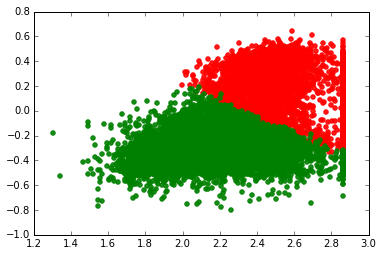

In [25]:
plt.scatter(Mira_cluster_x,Mira_cluster_y,alpha = 0.9, color = 'red')
plt.scatter(SRV_cluster_x,SRV_cluster_y,alpha = 0.9, color = 'green')

plt.show()

## SVM metoda (Support vector machine) ##

Předchozí metoda hledala optimální středy daného počtu shluků reprezentujícíh určitý typ proměnnosti a příslušnost dané hvězdy k shluku byla určena na základě vzdálenosti od shluku. Jiný přístup je použit u metody SVM. SVM hledá nadrovinu, která v prostoru příznaků (popisných parametrů) optimálně rozděluje trénovací data. Optimální nadrovina je taková, že body leží v opačných poloprostorech a hodnota minima vzdáleností bodů od roviny je co největší. Jinými slovy, okolo nadroviny je na obě strany co nejširší pruh bez bodů (maximální odstup). Metoda je ve své podstatě binární, rozděluje prostor popisných parametrů na dvě části. Způsob rozdělení závisí na zvoleném kernelu, od jedoduchého lineárního až po složitější polynomický kernel, resp. sigmoid.

Nejprve naimportujeme potřebné knihovny, jako první příklad zvolíme lineárni typ separace, který bude našem případu poměrně dobře odpovídat. Následně zvolíme z naší tabulky část dat, kterou použijeme jako trénovací množinu. Velikost trénovací množiny necháme jako volný parametr *train_index*. Inicializujeme objekt pro lineární SVM algoritmus pro klasifikaci *LinearSVC()* a jeho metodu *fit* aplikujeme na připravená tréninková data. Prvním parametrem je pole, kde sloupce odpovídají příslušným popisným parametrům (jakými je amplituda, perioda, střední hodnota magnitudy v daném filtru apod.) a řádky jednotlivým hvězdám.  Druhým parametrem je sloupec hodnot označujících příslušnost k danému typu, v našem případě 1 a 0.

In [26]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

train_index = 400

clf = LinearSVC()
clf.fit(data[:train_index],label_class_number[:train_index])


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Po naučení metoda umí rozpoznat příslušnost k dané třídě, což vyzkoušíme na testovací množině, kterou máme k dispozici ze zbývajících dat bez trénovací množiny. Výsledek předpovědi tak můžeme lehce porovnat s klasifikací z článku zavoláním metody *predict*, jejímž výstupem je pole označující příslušnost k danému typu (opět 0 a 1)

In [27]:
from __future__ import division

label_predict = clf.predict(data)

test_set = np.asarray(label_class_number[train_index+1:],dtype = np.int)
predict_set = np.asarray(label_predict[train_index+1:],dtype = np.int)

result_svm = test_set == predict_set

false_identification = np.size(np.where(result_svm == False))
precision = false_identification/np.size(test_set)

print 'Test set size:',np.size(test_set),', Number of false identification:',np.size(np.where(result_svm == False))
print 'Precision: ',precision

false_candidates_M_indexes = np.where(test_set[np.where(result_svm == False)] == 0)
false_candidates_SR_indexes = np.where(test_set[np.where(result_svm == False)] == 1)

Test set size: 8277 , Number of false identification: 229
Precision:  0.0276670291168


Nyní si zobrazíme do grafu *log(Per)* a *log(Amp)* špatně určené typy, tedy případy kdy metoda neidentifikovala daný typ správně, abychom zjistili jejich rozložení v tomto grafu.

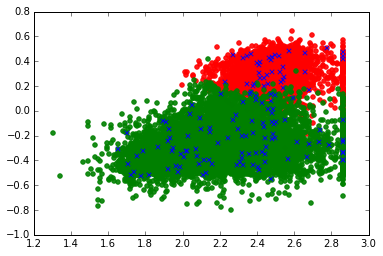

In [28]:
false_class_M_x = data[false_candidates_M_indexes,1]
false_class_M_y = data[false_candidates_M_indexes,2]

plt.scatter(x_M,y_M,alpha = 0.9, color = 'red')
plt.scatter(x_SR,y_SR,alpha = 0.9, color = 'green')

plt.scatter(false_class_M_x,false_class_M_y,alpha = 0.9, color = 'blue', marker='x')
plt.show()

Pro srovnání si opět vytvoříme speciální tabulku *Confusion matrix*, která vystihuje přesnost a úspěšnost klasifikačního modelu.

In [29]:
# Creation of Confusion matrix

# First row - class M:  M & SR+L , value in percent
class_M_predicted_M_svm = np.size(np.where(label_class_number[np.where(result_svm == True)] == 0))
class_M_predicted_SR_svm = np.size(np.where(label_class_number[np.where(result_svm == False)] == 0))

# Second row - class SR+L: M & SR+L , value in percent
class_SR_predicted_M_svm = np.size(np.where(label_class_number[np.where(result_svm == False)] == 1))
class_SR_predicted_SR_svm = np.size(np.where(label_class_number[np.where(result_svm == True)] == 1))


confusion_table = Table()

confusion_table['ID'] = Column(['M','SR'])
confusion_table['M'] = Column([(class_M_predicted_M_svm)*100/number_of_class_M,\
                    (class_SR_predicted_M_svm)*100/number_of_class_SR])

confusion_table['SR'] = Column([(class_M_predicted_SR_svm)*100/number_of_class_M,\
                    (class_SR_predicted_SR_svm)*100/number_of_class_SR])

confusion_table['M'].format = '.2f'
confusion_table['SR'].format = '.2f'

confusion_table.pprint()


 ID   M     SR 
--- ----- -----
  M 92.79  2.69
 SR  2.62 92.72


Vidíme, že metoda je mnohem přesnější v porovnání s předchozí *k-mean* procedurou. Je ale jasné, že je možné s vysokou přesností klasifikovat pozorovaná data s pomocí zmíněné metody na typ *M* a *SR-L*.

Balík [AstroML](http://http://www.astroml.org) a [sci-kit learn](http://scikit-learn.org/stable/) obsahují další metody pro klasifikaci, jak s učením tak bez učení, které je možné vyzkoušet na těchto datech a porovnat jejich úspěšnost.